In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

**On making the selection of cases within a specific Article:**

Number of cases with '3' appearing at least once in conclusion:

In [ ]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("glnmario/ECHR")

# Initialize a counter
count = 0

# Iterate through the dataset
for case in ds['train']:
    if 'conclusion' in case and '3' in case['conclusion']:
        count += 1

print(f"Number of cases with '3' in the conclusion: {count}")

Number of cases with '3' in the conclusion: 3207


Number of cases with variants of 'Article 3' appearing at least once in conclusion:

In [ ]:
import re

# Compile a regex pattern to match various instances of 'article 3'
pattern = re.compile(r'\b(?:article|art|articles|arts|Articles|Arts)\.? ?3\b', re.IGNORECASE)

# Initialize a counter
count = 0

# Iterate through the dataset
for case in ds['train']:
    if 'conclusion' in case and pattern.search(case['conclusion']):
        count += 1

print(f"Number of cases with various forms of 'article 3' in the conclusion: {count}")

Number of cases with various forms of 'article 3' in the conclusion: 1456


Text files of those that appear in '3' code, but are excluded in 'Article 3 variants' code

In [ ]:
# Initialize a set to hold the texts of relevant conclusions
conclusions_in_code1 = set()
conclusions_in_code2 = set()

# Collect conclusions from Code 1
for case in ds['train']:
    if 'conclusion' in case and '3' in case['conclusion']:
        conclusions_in_code1.add(case['conclusion'])

# Collect conclusions from Code 2
for case in ds['train']:
    if 'conclusion' in case and pattern.search(case['conclusion']):
        conclusions_in_code2.add(case['conclusion'])

# Find differences - cases in Code 1 but not in Code 2
unique_to_code_1 = conclusions_in_code1 - conclusions_in_code2

# Print the conclusions
print("Conclusions included in Code 1 but excluded in Code 2:")
for conclusion in unique_to_code_1:
    print(conclusion)

Conclusions included in Code 1 but excluded in Code 2:
Violation of Art. 6-1+6-3-c;Violation of Art. 6-3-e;Remainder inadmissible;Non-pecuniary damage - award
Preliminary objection dismissed (non-exhaustion of domestic remedies);Violation of Art. 5-3;Remainder inadmissible;Non-pecuniary damage - financial award;Costs and expenses (domestic proceedings) - claim dismissed;Costs and expenses partial award - Convention proceedings
Violation of Art. 5-3;Violation of Art. 5-5;Violation of Art. 6-1;Remainder inadmissible
No violation of Article 5 - Right to liberty and security (Article 5-3 - Length of pre-trial detention;Reasonableness of pre-trial detention);No violation of Article 6+6-3-d - Right to a fair trial (Article 6 - Criminal proceedings;Article 6-1 - Fair hearing) (Article 6-3-d - Obtain attendance of witnesses;Article 6 - Right to a fair trial);Violation of Article 6+6-3-d - Right to a fair trial (Article 6 - Criminal proceedings;Article 6-1 - Fair hearing) (Article 6 - Criminal 

**Gender identification following a simple code:**

Number of male/female/other applicants in Article 3 based on 'he' and 'she' appearing in the first 5 sentences:

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Convert all splits to pandas DataFrames and concatenate them
df_list = [pd.DataFrame(ds[split]) for split in ds.keys()]
df = pd.concat(df_list, ignore_index=True)

# Function to extract the first five sentences
def extract_first_five_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return ' '.join(sentences[:5])

# Function to identify gender from text
def identify_gender(text):
    text = extract_first_five_sentences(text)

    # Check for male indicators
    if ' He ' in text or ' he ' in text:
        return 'male'

    # Check for female indicators
    if ' She ' in text or ' she ' in text:
        return 'female'

    return 'other'

# Filter the cases based on all variants of "Article 3" in the conclusion
cases = df[df['conclusion'].str.contains(pattern, na=False)]

# Apply the gender identification function
df['gender'] = df['text'].apply(identify_gender)

# Filter the cases based on all variants of "Article 3" in the conclusion
cases = df[df['conclusion'].str.contains(pattern, na=False)]

# Count violations and non-violations based on gender
gender_violation_counts = cases.groupby(['gender', 'binary_judgement']).size().unstack(fill_value=0)

# Extract totals for each gender and violation status
male_violations = gender_violation_counts.at['male', 1] if 'male' in gender_violation_counts.index and 1 in gender_violation_counts.columns else 0
male_non_violations = gender_violation_counts.at['male', 0] if 'male' in gender_violation_counts.index and 0 in gender_violation_counts.columns else 0
female_violations = gender_violation_counts.at['female', 1] if 'female' in gender_violation_counts.index and 1 in gender_violation_counts.columns else 0
female_non_violations = gender_violation_counts.at['female', 0] if 'female' in gender_violation_counts.index and 0 in gender_violation_counts.columns else 0

# Total counts for males, females, and others
male_count = gender_violation_counts.loc['male'].sum() if 'male' in gender_violation_counts.index else 0
female_count = gender_violation_counts.loc['female'].sum() if 'female' in gender_violation_counts.index else 0
other_count = len(cases) - (male_count + female_count)

print(f"Total Male Applicants in Article 3 cases: {male_count}")
print(f"Total Female Applicants in Article 3 cases: {female_count}")
print(f"Total Other Applicants in Article 3 cases: {other_count}")

Total Male Applicants in Article 3 cases: 498
Total Female Applicants in Article 3 cases: 77
Total Other Applicants in Article 3 cases: 881


Number of male/female violations and significance:

Number of Violations and Non-Violations in Article 3 Cases based on gender:
Male Violations: 436 (87.55%)
Male Non-Violations: 62 (12.45%)
Female Violations: 64 (83.12%)
Female Non-Violations: 13 (16.88%)

Chi-Square Test Results:
Chi-Square Statistic: 0.7977988795006876
P-Value: 0.37175228422290485
There is no significant difference between male and female violation/non-violation rates.


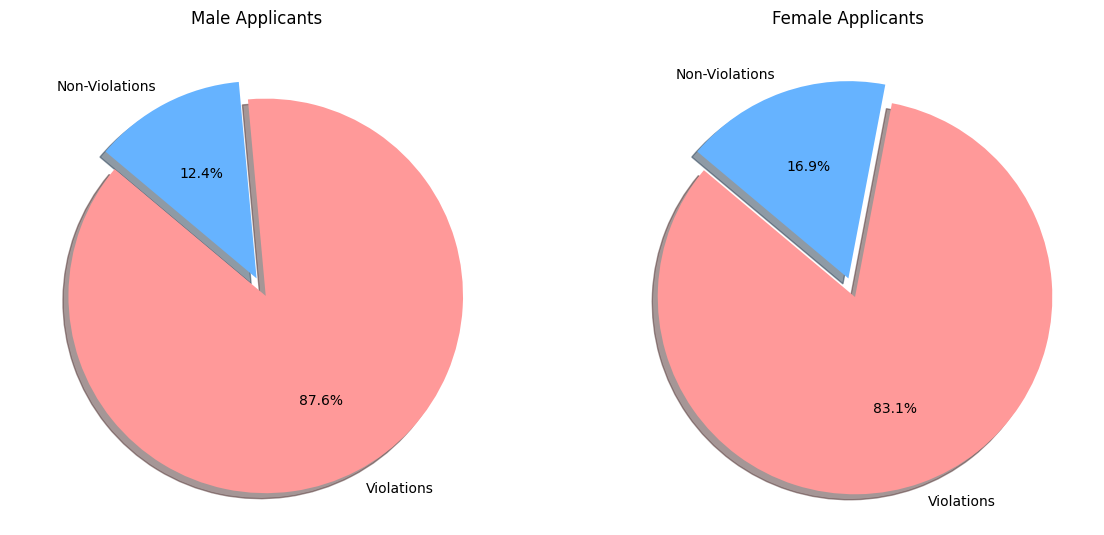

In [ ]:
# Create a contingency table for the Chi-Square test
contingency_table = [
    [male_violations, female_violations],
    [male_non_violations, female_non_violations]
]

# Perform the Chi-Square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Calculate percentages
male_violations_percentage = (male_violations / male_count) * 100 if male_count > 0 else 0
male_non_violations_percentage = (male_non_violations / male_count) * 100 if male_count > 0 else 0
female_violations_percentage = (female_violations / female_count) * 100 if female_count > 0 else 0
female_non_violations_percentage = (female_non_violations / female_count) * 100 if female_count > 0 else 0

# Display the counts, percentages, and Chi-Square test results
print("Number of Violations and Non-Violations in Article 3 Cases based on gender:")
print(f"Male Violations: {male_violations} ({male_violations_percentage:.2f}%)")
print(f"Male Non-Violations: {male_non_violations} ({male_non_violations_percentage:.2f}%)")
print(f"Female Violations: {female_violations} ({female_violations_percentage:.2f}%)")
print(f"Female Non-Violations: {female_non_violations} ({female_non_violations_percentage:.2f}%)")

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

if p < 0.05:
    print("There is a significant difference between male and female violation/non-violation rates.")
else:
    print("There is no significant difference between male and female violation/non-violation rates.")

import matplotlib.pyplot as plt

# Pie chart for male applicants
labels = ['Violations', 'Non-Violations']
sizes = [male_violations, male_non_violations]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)  # 1 row, 2 column, 1st subplot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Male Applicants')

# Pie chart for female applicants
sizes = [female_violations, female_non_violations]

plt.subplot(1, 2, 2)  # 1 row, 2 column, 2nd subplot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Female Applicants')

plt.show()

In [ ]:
import random
import re

# Function to extract the first five sentences
def extract_first_five_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return ' '.join(sentences[:5])

# Select samples that ended up in the 'other' category
other_cases = df[df['gender'] == 'other']

# Sample 50 random cases from the 'other' category
sample_other_cases = other_cases.sample(n=50, random_state=42) if len(other_cases) > 50 else other_cases

# Apply the function to extract the first five sentences
sample_other_cases['first_five_sentences'] = sample_other_cases['text'].apply(extract_first_five_sentences)

# Print the first 5 sentences for the 50 samples
for index, row in sample_other_cases.iterrows():
    print(f"Sample {index+1}: {row['first_five_sentences']}\n")

Sample 7428: 4. The applicants were born in 1960, 1955, 1948, 1942 and 1958 respectively and live in Şanlıurfa. 5. On 22 November 1984 Law no. 3083 came into force.

Sample 5356: 5. The applicant was born in 1961 in Gubadly and currently lives in Sumgayit. 6. The applicant and his family are internally displaced persons from Gubadly. In 1993, during the occupation of the region by Armenian military forces, they fled their permanent place of residence and came to Sumgayit.

Sample 8358: 6. At the material time, the applicant was the owner and editor of a weekly review entitled Haberde Yorumda Gerçek (The Truth of News and Comments), published in Istanbul. 7. On 5 September 1993 the Istanbul State Security Court ordered the seizure of the twenty-third edition of the review, dated 4 September 1993, on the ground that an article therein entitled Aydın İtirafı contained separatist propaganda. The article read: “Bir ulusun toptan yok edilmesini izliyoruz.

Sample 4941: 1. The applicants, Ms 